# Trying to resemble Bouttes more closely.

I don't think the current behaviour resembles Bouttes enough. We have been using parameters that are supposedly the same, so it should look like Bouttes. I don't know why it doesn't. We have a much larger temperature change than Bouttes does. That is not something we have altered..
-Have we used epsilon =1 properly?  => YES

What if we say we have reproduced Bouttes.. (But I'm not convinced). Then we have 2 tasks:

-Figure out parameter sensitivities
-See if a bigger kappa will give us more satifying differences in terms of asymmetry.

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

In [98]:
d_u = 100       # m
d_l = 2000      # m

alpha = 0.81    # W m^-2 K^-2
c = 4.218e6     # J m^-3 K^-1
k = 1e-4        # m^2 s^-1  

gamma = c * k / (0.5 * (d_l + d_u))
print(gamma)

C_0 = c * d_l / (60*60*24*365)
C = c * d_u / (60*60*24*365)


print(C_0/C)


0.40171428571428575
20.0


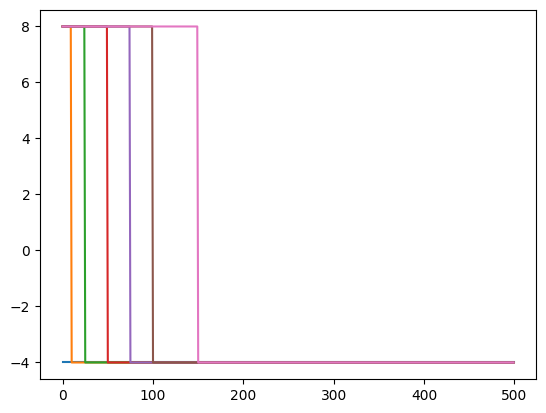

In [67]:
ts = np.array([0,10 ,25,50,75,100,150])

f_scenarios = {}

for t in ts:
    force = (np.ones(500) * -4)
    force[:t] *= -2
    f_scenarios[t] = force

for f in f_scenarios:
    plt.plot(f_scenarios[f])


run_names = []


for t in ts:
    run_names.append(f"t = %s, k = %s" %(t,0))
    run_names.append(f"t = %s, k = %s" %(t,0.1))

In [50]:
#Running with Geoffroy parameters but Bouttes Heat capacity. dt=3 for speed. epsilon=1

runs = {}
kappas = [0, 0.1]
#ts = [0]

for kappa in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(kappa,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=1.18,
                t2x=None,
                eff=1, #No epsilon
                cmix=C,
                cdeep=C_0,
                gamma_2l=0.67,
                kappa=kappa, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=3
            )
        
            out = scm.run()
    
        runs[f"t = %s, k = %s" %(t,kappa)] = out

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [00:17<00:00, 58.56it/s]


currently on kappa 0, t:10 


100%|██████████| 1000/1000 [00:14<00:00, 70.15it/s]


currently on kappa 0, t:25 


100%|██████████| 1000/1000 [00:13<00:00, 75.47it/s]


currently on kappa 0, t:50 


100%|██████████| 1000/1000 [00:18<00:00, 55.50it/s]


currently on kappa 0, t:75 


100%|██████████| 1000/1000 [00:22<00:00, 45.34it/s]


currently on kappa 0, t:100 


100%|██████████| 1000/1000 [00:20<00:00, 49.42it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:20<00:00, 48.67it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:23<00:00, 41.96it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:19<00:00, 50.63it/s]


currently on kappa 0.1, t:25 


100%|██████████| 1000/1000 [00:19<00:00, 50.89it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:20<00:00, 49.55it/s]


currently on kappa 0.1, t:75 


100%|██████████| 1000/1000 [00:20<00:00, 49.24it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:18<00:00, 54.49it/s]


0
10
25
50
75
100
150
0.4694272764730122 50.325504738360124
0.7470539761021843 46.52327976926259


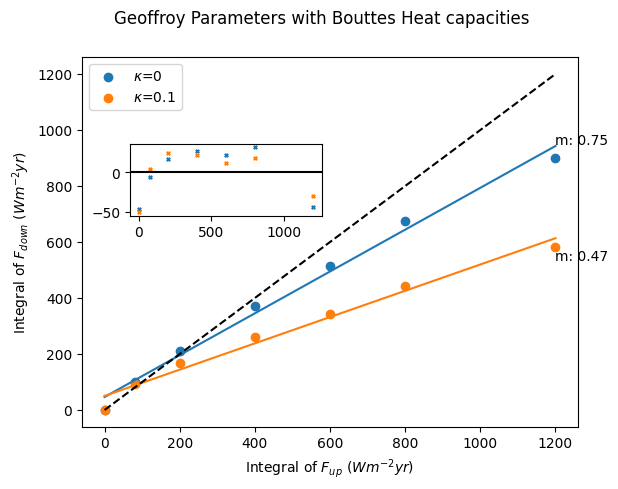

In [56]:
import matplotlib.pyplot as plt
#import math
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time
#ts = [10,25,50, 75, 100]


#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

t_0k = []
t_01k = []
return_times = {}

ts_instance = []
for scen in runs:
    run = runs[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #ts_instance.append(t)
    #print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i][0]
    if k == "0":
        print(t)
        fint_up.append(8 * t)
        t_0k.append(run.time[i][0])
        fint_down0.append(4 * (run.time[i][0]-t))
    else:
        t_01k.append(run.time[i][0])
        fint_down01.append(4 * (run.time[i][0]-t))

#print(t_0k, t_01k)
#print(return_times)
#print(ts_instance)


#fint_up = np.sort(fint_up)

#for ind, t in enumerate(ts_instance):
  #  fint_up.append( 8 * t)
  #  fint_down0.append(4 * (t_0k[ind]-t))
   # fint_down01.append(4 * (t_01k[ind]-t))


#Fitting using lstsqs

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
print(m1,c1)

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
print(m0,c0)

xs = np.array(fint_up)
residuals0 = (fint_down0 - ( m0 * xs + c0) )
residuals01 = (fint_down01 - ( m1 * xs + c1 ))

fig, axs = plt.subplots()
fig.suptitle("Geoffroy Parameters with Bouttes Heat capacities")

axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
axs.plot(xs, m0 * xs + c0)
axs.plot(xs, m1 * xs + c1)
axs.plot(np.sort(xs), np.sort(xs), "k", linestyle= "dashed")
axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1],fint_down0[-1]+50))
axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1],fint_down01[-1]-50 ))
axs.legend()


l, b, h, w = .2, .55, .15, .3
ax2 = fig.add_axes([l, b, w, h])
ax2.scatter(xs, residuals0, marker="x", s = 6)
ax2.scatter(xs, residuals01, marker="x", s = 6)
ax2.axhline(0, color="k")

796.0


Text(0.5, 1.0, 'Geoffroy Parameters with Bouttes Heat capacities')

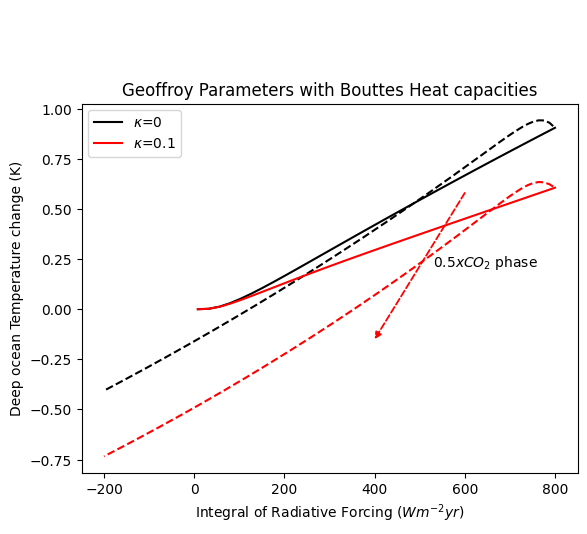

In [57]:
for name in runs:
    #print(name)
    i = name.index("t")
    j = name.index(",")
    t = int(name[i+4:j])
    if t != 100:
        continue 
    l = name.index("k")
    k = name[l+4:]
    #print(k)
    if k == "0":
        color = "black"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0")
        plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    if k == "0.1":
        color = "red"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0.1")
        print(f_up[-1] + f_down[0])
        plt.plot(f_down[:250] + f_up[-1], run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
    plt.ylabel("Deep ocean Temperature change (K)")
    #plt.xlim(-500,3000)
    plt.legend()

arrowStart=np.array([400,-0.15])
arrowStop=np.array([600,0.58])
arrowColor="red"
plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+30,((arrowStop+arrowStart)/2)[1]) )
plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

arrowStart2=np.array([620,1.5])
arrowStop2=np.array([400,1])
arrowColor2="red"
plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))
plt.title("Geoffroy Parameters with Bouttes Heat capacities")

Larger heat capacity ratios mask the effects of temp. dependent gammas. Let's try with a much smaller ratio..

In [59]:
print(C,C_0)

13.375190258751903 267.50380517503805


In [60]:
#Running with Geoffroy parameters but heat capacity ratio of C_0/C = 5

runs_5ratio = {}
kappas = [0, 0.1]
#ts = [0]

for kappa in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(kappa,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=1.18,
                t2x=None,
                eff=1, #No epsilon
                cmix=C_0/5,
                cdeep=C_0,
                gamma_2l=0.67,
                kappa=kappa, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=3
            )
        
            out = scm.run()
    
        runs_5ratio[f"t = %s, k = %s" %(t,kappa)] = out

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [00:21<00:00, 45.66it/s]


currently on kappa 0, t:10 


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


currently on kappa 0, t:25 


100%|██████████| 1000/1000 [00:20<00:00, 47.92it/s]


currently on kappa 0, t:50 


100%|██████████| 1000/1000 [00:21<00:00, 45.79it/s]


currently on kappa 0, t:75 


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


currently on kappa 0, t:100 


100%|██████████| 1000/1000 [00:17<00:00, 56.20it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:18<00:00, 55.32it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:18<00:00, 52.85it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:18<00:00, 54.18it/s]


currently on kappa 0.1, t:25 


100%|██████████| 1000/1000 [00:18<00:00, 53.63it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:18<00:00, 53.19it/s]


currently on kappa 0.1, t:75 


100%|██████████| 1000/1000 [00:20<00:00, 49.32it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:19<00:00, 52.01it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:19<00:00, 52.46it/s]


0
10
25
50
75
100
150
0.6084260403790692 94.90894107952217
0.8137000412031319 77.58055212196128


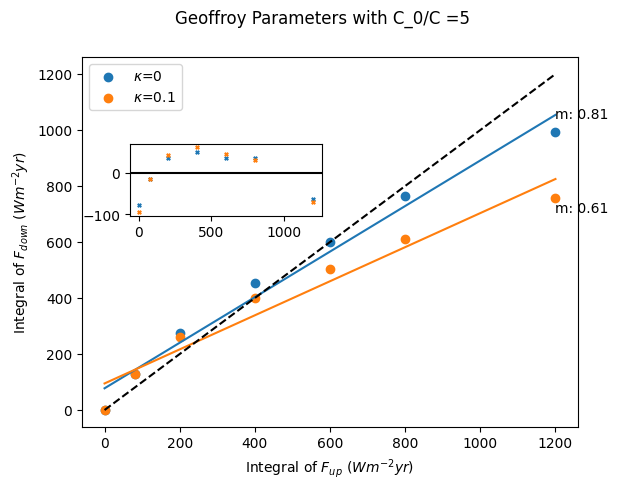

In [61]:

#import math
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time
#ts = [10,25,50, 75, 100]


#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

t_0k = []
t_01k = []
return_times = {}

ts_instance = []
for scen in runs_5ratio:
    run = runs_5ratio[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #ts_instance.append(t)
    #print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i][0]
    if k == "0":
        print(t)
        fint_up.append(8 * t)
        t_0k.append(run.time[i][0])
        fint_down0.append(4 * (run.time[i][0]-t))
    else:
        t_01k.append(run.time[i][0])
        fint_down01.append(4 * (run.time[i][0]-t))

#print(t_0k, t_01k)
#print(return_times)
#print(ts_instance)


#fint_up = np.sort(fint_up)

#for ind, t in enumerate(ts_instance):
  #  fint_up.append( 8 * t)
  #  fint_down0.append(4 * (t_0k[ind]-t))
   # fint_down01.append(4 * (t_01k[ind]-t))


#Fitting using lstsqs

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
print(m1,c1)

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
print(m0,c0)

xs = np.array(fint_up)
residuals0 = (fint_down0 - ( m0 * xs + c0) )
residuals01 = (fint_down01 - ( m1 * xs + c1 ))

fig, axs = plt.subplots()
fig.suptitle("Geoffroy Parameters with C_0/C =5")

axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
axs.plot(xs, m0 * xs + c0)
axs.plot(xs, m1 * xs + c1)
axs.plot(np.sort(xs), np.sort(xs), "k", linestyle= "dashed")
axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1],fint_down0[-1]+50))
axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1],fint_down01[-1]-50 ))
axs.legend()


l, b, h, w = .2, .55, .15, .3
ax2 = fig.add_axes([l, b, w, h])
ax2.scatter(xs, residuals0, marker="x", s = 6)
ax2.scatter(xs, residuals01, marker="x", s = 6)
ax2.axhline(0, color="k")

796.0


Text(0.5, 1.0, 'Geoffroy Parameters with C/C_0 =5')

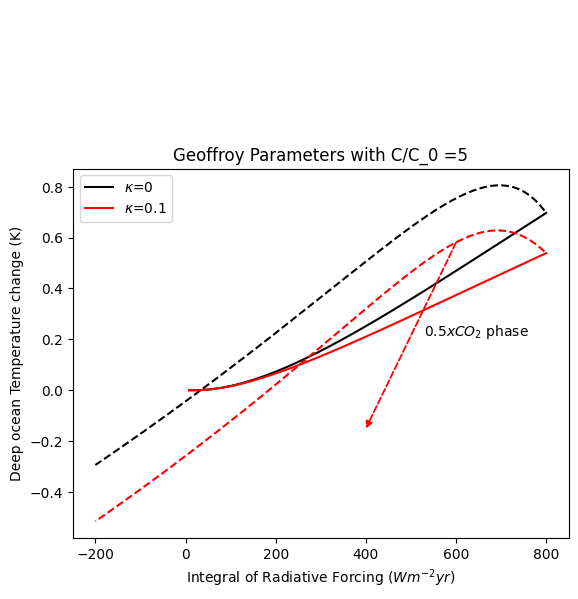

In [65]:
for name in runs_5ratio:
    #print(name)
    i = name.index("t")
    j = name.index(",")
    t = int(name[i+4:j])
    if t != 100:
        continue 
    l = name.index("k")
    k = name[l+4:]
    #print(k)
    if k == "0":
        color = "black"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs_5ratio[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0")
        plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    if k == "0.1":
        color = "red"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs_5ratio[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0.1")
        print(f_up[-1] + f_down[0])
        plt.plot(f_down[:250] + f_up[-1], run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
    plt.ylabel("Deep ocean Temperature change (K)")
    #plt.xlim(-500,3000)
    plt.legend()

arrowStart=np.array([400,-0.15])
arrowStop=np.array([600,0.58])
arrowColor="red"
plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+30,((arrowStop+arrowStart)/2)[1]) )
plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

arrowStart2=np.array([620,1.5])
arrowStop2=np.array([400,1])
arrowColor2="red"
plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))
plt.title("Geoffroy Parameters with C/C_0 =5")

In [125]:
    ratio = 20
    
    d_u = 3000/(1+ratio)       # m
    d_l = 3000-d_u      # m
    

    alpha = 0.81    # W m^-2 K^-2
    c = 4.218e6     # J m^-3 K^-1
    k = 1e-4        # m^2 s^-1  

    gamma = c * k / (0.5 * (d_l + d_u))
    print(gamma)

0.2812


In [126]:

def RunWithC_ratio(kappas, ts, ratio=20, lam=0.81, epsilon=1, gamma =0.2812 ):
    """
    Runs with Bouttes parameters. Want to see whether we can get perfect symmetry.
    outputs dictionary with runs using desired ratio d_l/d_r. Original ratio is 20
    """
    f_scenarios = {}

    for t in ts:    
        force = (np.ones(500) * -4)
        force[:t] *= -2
        f_scenarios[t] = force

    d_u = 3000/(1+ratio)       # m
    d_l = 3000-d_u      # m
    

    alpha = 0.81    # W m^-2 K^-2
    c = 4.218e6     # J m^-3 K^-1
    k = 1e-4        # m^2 s^-1  

    gamma = c * k / (0.5 * (d_l + d_u))
    print(gamma)

    C_0 = c * d_l / (60*60*24*365)
    C = c * d_u / (60*60*24*365)
    print(C,C_0)


    runs = {}
    for kappa in kappas:    
        for t in ts:
            print(f"currently on kappa %s, t:%s " %(kappa,t))
            for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
                scm = TwoLayerModel(
                    extforce= f_scenarios[t],
                    exttime=np.arange(0,500),
                    tbeg=0,
                    tend=500,
                    lamg=l,
                    t2x=None,
                    eff=1, #No epsilon
                    cmix=C,
                    cdeep=C_0,
                    gamma_2l=g,
                    kappa=kappa, 
                    sigma = 0.01,
                    outtime=np.arange(0,500),
                    dt=5   
                )
        
                out = scm.run()
    
            runs[f"t = %s, k = %s" %(t,kappa)] = out
    
    return runs


In [105]:


#Forcing Integrals

def plotFupVFdown(runs, r, Plot = False):
    fint_up = []
    fint_down0 = [] #when kappa = 0
    fint_down01 = [] #when kappa = 0.1

    t_0k = []
    t_01k = []
    return_times = {}

    ts_instance = []
    for scen in runs:
        run = runs[scen] 
        #print(scen)
        t = int(scen[scen.find("= ")+2:scen.find(", ")])
        k = (scen[scen.find("k = ")+4:])
        #print(k)
        #ts_instance.append(t)
        #print(t)
        minv= min(abs(run.tlev[:,1])[t:])
        i = np.where(abs(run.tlev[:,1]) == minv)
        return_times[scen] = run.time[i][0]
        if k == "0.0":
            #print(t)
            fint_up.append(8 * t)
            t_0k.append(run.time[i][0])
            fint_down0.append(4 * (run.time[i][0]-t))
        else:
            t_01k.append(run.time[i][0])
            fint_down01.append(4 * (run.time[i][0]-t))


#Fitting using lstsqs

    A = np.vstack([fint_up, np.ones(len(fint_up))]).T
    m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
    #print(m1,c1)

    A = np.vstack([fint_up, np.ones(len(fint_up))]).T
    m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
    #print(m0,c0)
    if Plot == True:

        xs = np.array(fint_up)
        residuals0 = (fint_down0 - ( m0 * xs + c0) )
        residuals01 = (fint_down01 - ( m1 * xs + c1 ))

        fig, axs = plt.subplots()
        fig.suptitle(f"Bouttes Parameters with C_0/C =%s"%r)

        axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
        axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
        axs.plot(xs, m0 * xs + c0)
        axs.plot(xs, m1 * xs + c1)
        axs.plot(np.sort(xs), np.sort(xs), "k", linestyle= "dashed")
        axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
        axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
        axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1],fint_down0[-1]+50))
        axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1],fint_down01[-1]-50 ))
        axs.legend()


        l, b, h, w = .2, .55, .15, .3
        ax2 = fig.add_axes([l, b, w, h])
        ax2.scatter(xs, residuals0, marker="x", s = 6)
        ax2.scatter(xs, residuals01, marker="x", s = 6)
        ax2.axhline(0, color="k")
    
    return m0,m1

In [106]:
def plotFvsTemp(runs):
    for name in runs:
        #print(name)
        i = name.index("t")
        j = name.index(",")
        t = int(name[i+4:j])
        if t != 100:
            continue 
        l = name.index("k")
        k = name[l+4:]
        #print(k)
        if k == "0":
            color = "black"
            force = f_scenarios[t]
            f_up = np.cumsum(force[:t])
            f_down = np.cumsum(force[t:])
            run = runs[name]
            plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0")
            plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
        if k == "0.1":
            color = "red"
            force = f_scenarios[t]
            f_up = np.cumsum(force[:t])
            f_down = np.cumsum(force[t:])
            run = runs[name]
            plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0.1")
            #print(f_up[-1] + f_down[0])
            plt.plot(f_down[:250] + f_up[-1], run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
        plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
        plt.ylabel("Deep ocean Temperature change (K)")
        #plt.xlim(-500,3000)
        plt.legend()

    arrowStart=np.array([400,-0.15])
    arrowStop=np.array([600,0.58])
    arrowColor="red"
    plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+30,((arrowStop+arrowStart)/2)[1]) )
    plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

    arrowStart2=np.array([620,1.5])
    arrowStop2=np.array([400,1])
    arrowColor2="red"
    plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
    plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))
    plt.title("Geoffroy Parameters with C/C_0 =5")

In [87]:


ts = np.array([0,10 ,25,50,75,100,150])


In [ ]:
#masterdic_forRatio = {}

In [90]:
kappas = [0., 0.1]
ts = np.array([0,10,50,100,150])
ratios = [10,20,40]
masterdic_forRatio = {}

for r in ratios:
    masterdic_forRatio[r]= RunWithC_ratio(r,kappas,ts)


0.2812
36.47779161477792 364.77791614777914
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:11<00:00, 84.42it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:11<00:00, 87.59it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 101.60it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:21<00:00, 46.66it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:10<00:00, 97.78it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:09<00:00, 110.88it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:09<00:00, 110.14it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 108.87it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:09<00:00, 108.87it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 111.30it/s]


0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:10<00:00, 97.91it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:11<00:00, 86.50it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:10<00:00, 97.58it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:09<00:00, 100.91it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:10<00:00, 98.53it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:14<00:00, 67.21it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:10<00:00, 94.87it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 110.28it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:09<00:00, 106.72it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 113.31it/s]


0.2812
9.786724579574564 391.4689831829825
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:08<00:00, 118.57it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:08<00:00, 120.22it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:08<00:00, 116.80it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:08<00:00, 114.43it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 116.57it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:08<00:00, 119.89it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:08<00:00, 114.01it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:08<00:00, 114.38it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:08<00:00, 118.16it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 117.19it/s]


10 (0.9771410579345089, 0.5129722921914358)
20 (0.9257556675062975, 0.3130982367758188)
40 (0.9006926952141062, 0.17871536523929477)


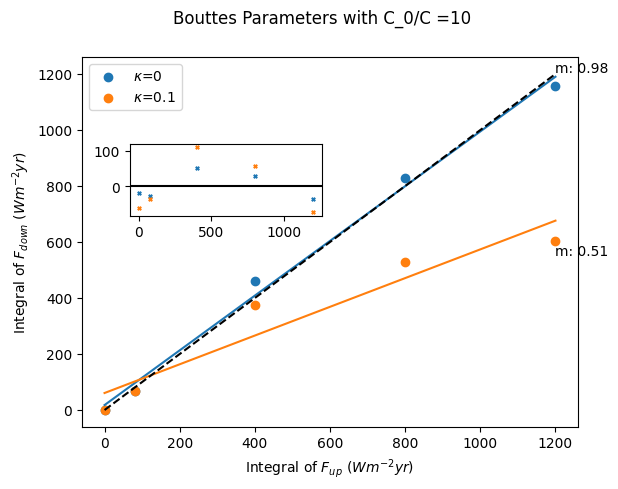

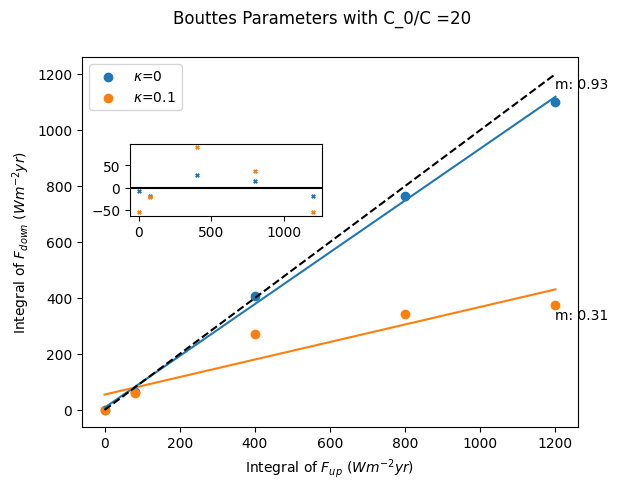

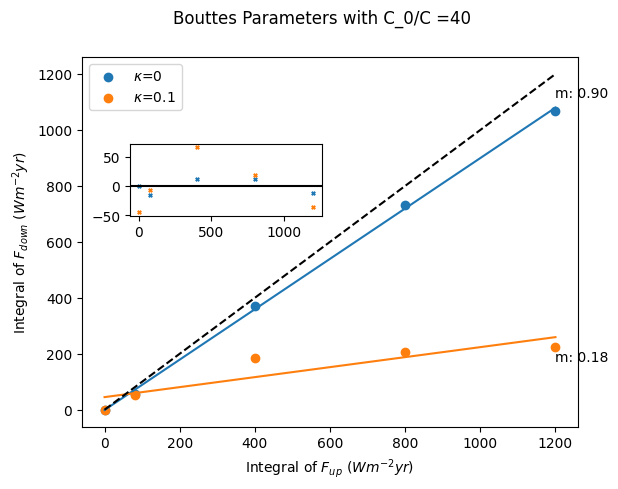

In [97]:
for r in ratios:
    print(r, plotFupVFdown(masterdic_forRatio[r], r, Plot=True))


In [114]:
kappas = [0., 0.1]
ts = np.array([0,10,50,100,150])
ratio = 20
masterdic_for_epsilon = {}
epsilons = [1,1.28]

for epsilon in epsilons:
    masterdic_for_epsilon[epsilon]= RunWithC_ratio(ratio,kappas,ts, epsilon)

0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:15<00:00, 63.42it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:11<00:00, 89.34it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:09<00:00, 105.32it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:09<00:00, 107.39it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:10<00:00, 93.00it/s] 


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:10<00:00, 97.25it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:11<00:00, 87.45it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:11<00:00, 86.40it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:10<00:00, 90.94it/s]


0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:10<00:00, 95.94it/s] 


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:10<00:00, 97.50it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:13<00:00, 73.66it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:10<00:00, 96.78it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:11<00:00, 86.97it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:11<00:00, 85.28it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:12<00:00, 82.76it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:11<00:00, 84.50it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:10<00:00, 98.43it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:09<00:00, 100.59it/s]


1 (0.9257556675062975, 0.3130982367758188)
1.28 (0.9277707808564235, 0.3341309823677582)


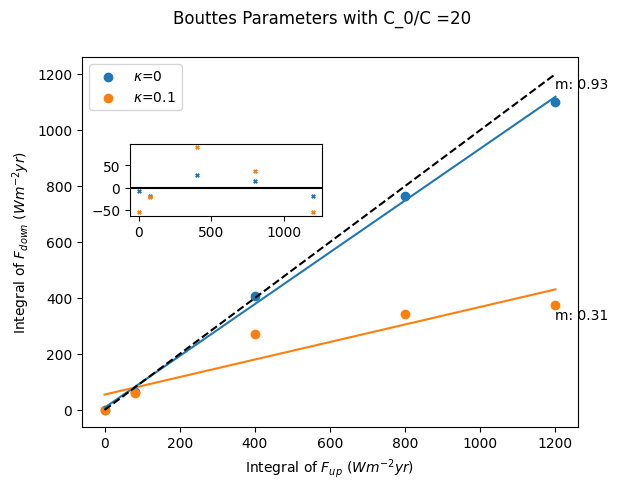

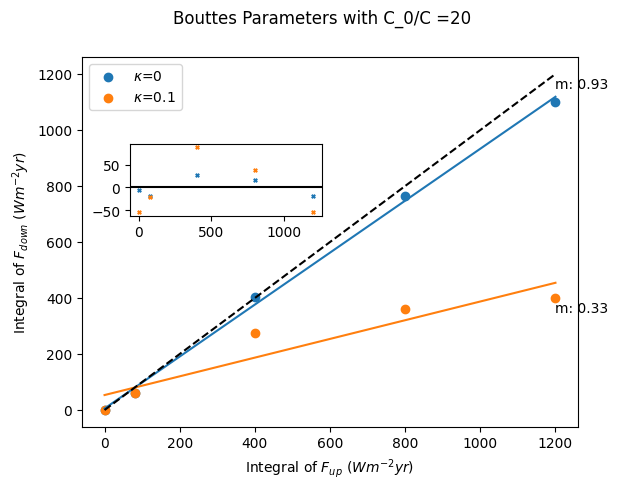

In [118]:
for epsilon in epsilons:
    #print(masterdic_for_epsilon[epsilon])
    print(epsilon, plotFupVFdown(masterdic_for_epsilon[epsilon], 20, Plot=True))


The effect of epsilon is not huge

# Trying lambda

In [122]:
lambdas = [0.81, 1.18]
ts = np.array([0,10,50,100,150])
kappas = [0.0,0.1]
masterdic_for_lambda = {}
ratio = 20

#Geoffroy had lambda = 1.18

for l in lambdas:
    masterdic_for_lambda[l] = RunWithC_ratio(ratio, kappas, ts, lam=l, epsilon=1)

0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:11<00:00, 87.72it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:10<00:00, 95.22it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:08<00:00, 112.69it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:09<00:00, 109.45it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:09<00:00, 109.91it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:09<00:00, 106.90it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:11<00:00, 89.05it/s] 


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 108.83it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:08<00:00, 117.10it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 119.52it/s]


0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:08<00:00, 111.36it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:10<00:00, 95.06it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 103.75it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:10<00:00, 94.25it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:10<00:00, 97.36it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:10<00:00, 96.75it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:09<00:00, 106.89it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:10<00:00, 98.30it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:10<00:00, 96.74it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:10<00:00, 98.97it/s]


0.81 (0.9257556675062975, 0.3130982367758188)
1.18 (0.9039042821158695, 0.44899244332493715)


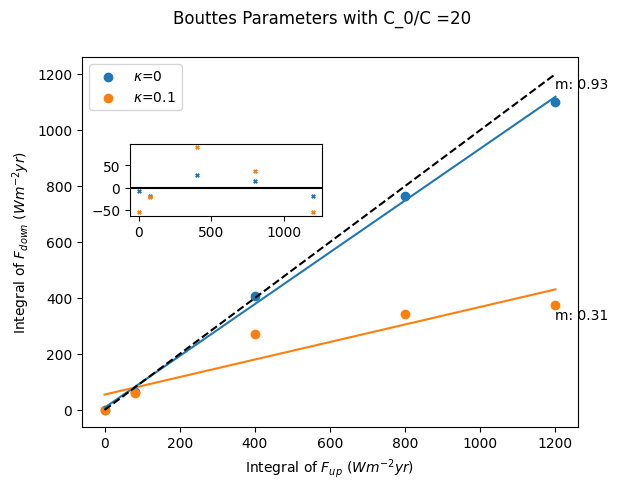

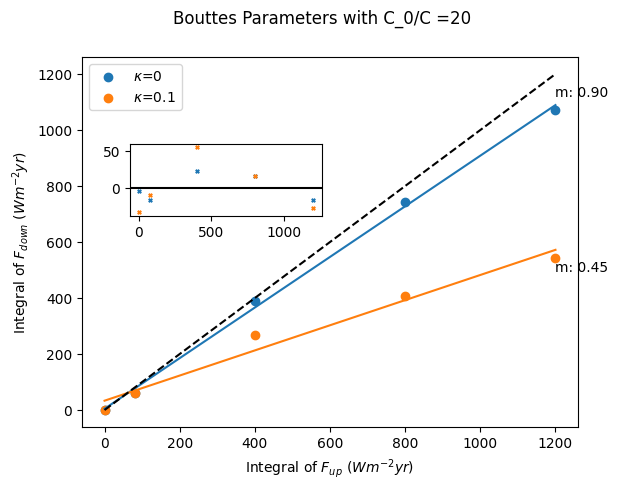

In [123]:
for l in lambdas:
    
    print(l, plotFupVFdown(masterdic_for_lambda[l], 20, Plot=True))

Lamda does affect behaviour, but is in itself not an explanation of the observed differences.

Finally, let's look at gamma_0

In [127]:
gammas = [0.2812, 0.67]
#Bouttes: 0.2812
#Geoffroy: 0.67




lambdas = [0.81, 1.18]
ts = np.array([0,10,50,100,150])
kappas = [0.0,0.1]
masterdic_for_gamma = {}


for g in gammas:
    masterdic_for_gamma[g] = RunWithC_ratio(kappas, ts, gamma = g, lam=l, epsilon=1)

0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:09<00:00, 111.07it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:09<00:00, 110.80it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 100.33it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:10<00:00, 96.45it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:13<00:00, 71.79it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:10<00:00, 97.62it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:12<00:00, 82.53it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:10<00:00, 94.66it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:09<00:00, 100.88it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:09<00:00, 102.43it/s]


0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:09<00:00, 105.86it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:10<00:00, 98.18it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 100.80it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:13<00:00, 73.83it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:10<00:00, 91.81it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:11<00:00, 88.42it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:09<00:00, 107.88it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:10<00:00, 98.80it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:10<00:00, 95.66it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:10<00:00, 94.23it/s]


0.2812 (0.9039042821158695, 0.44899244332493715)
0.67 (0.8186397984886654, 0.527581863979849)


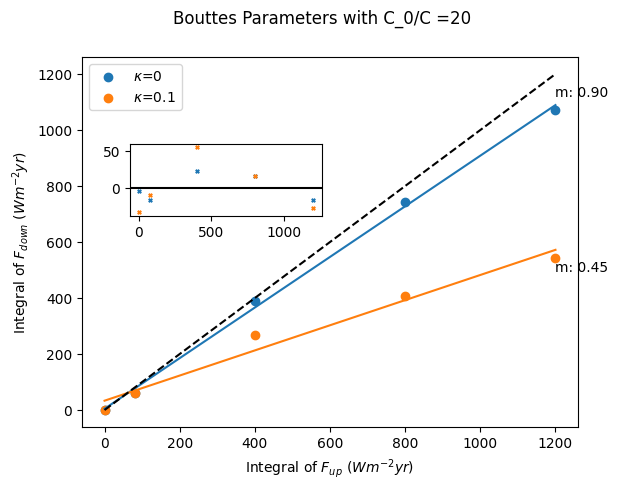

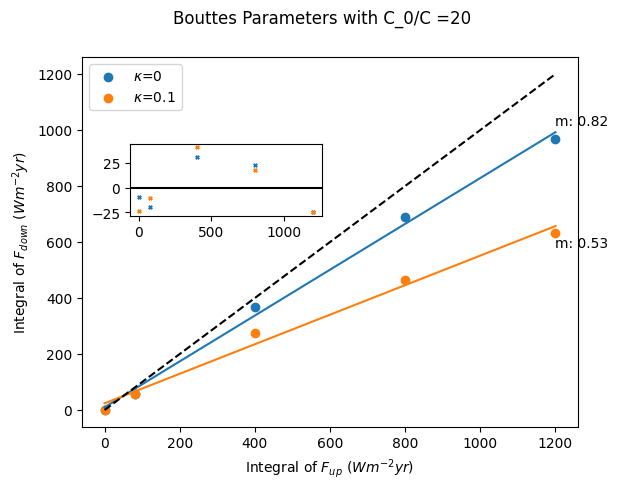

In [129]:
for g in gammas:
    
    print(g, plotFupVFdown(masterdic_for_gamma[g], 20, Plot=True))

Now Looking again at bigger kappas:

In [134]:
print(runManyKappas)

for name in runManyKappas:
    print(name)
    k = (name[name.find("k = ")+4:])
    print(k)
    #IntegralFinder()

{'t = 0, k = 0.0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 10, k = 0.0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 50, k = 0.0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 100, k = 0.0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 150, k = 0.0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 0, k = 0.1': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 10, k = 0.1': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 50, k = 0.1': Results, public attributes: ['gammas', 'hf

In [190]:
kappas = [0.0,0.05, 0.1, 0.15, 0.2]
ts = np.array([0,10,25,50,75,100,150])

runManyKappas = RunWithC_ratio(kappas, ts)

0.2812
19.10741465535986 382.1482931071972
currently on kappa 0.0, t:0 


100%|██████████| 1000/1000 [00:13<00:00, 72.17it/s]


currently on kappa 0.0, t:10 


100%|██████████| 1000/1000 [00:09<00:00, 106.35it/s]


currently on kappa 0.0, t:25 


100%|██████████| 1000/1000 [00:08<00:00, 111.39it/s]


currently on kappa 0.0, t:50 


100%|██████████| 1000/1000 [00:08<00:00, 123.49it/s]


currently on kappa 0.0, t:75 


100%|██████████| 1000/1000 [00:08<00:00, 111.58it/s]


currently on kappa 0.0, t:100 


100%|██████████| 1000/1000 [00:10<00:00, 95.96it/s]


currently on kappa 0.0, t:150 


100%|██████████| 1000/1000 [00:09<00:00, 106.83it/s]


currently on kappa 0.05, t:0 


100%|██████████| 1000/1000 [00:09<00:00, 110.32it/s]


currently on kappa 0.05, t:10 


100%|██████████| 1000/1000 [00:07<00:00, 132.87it/s]


currently on kappa 0.05, t:25 


100%|██████████| 1000/1000 [00:08<00:00, 123.66it/s]


currently on kappa 0.05, t:50 


100%|██████████| 1000/1000 [00:07<00:00, 133.53it/s]


currently on kappa 0.05, t:75 


100%|██████████| 1000/1000 [00:07<00:00, 133.66it/s]


currently on kappa 0.05, t:100 


100%|██████████| 1000/1000 [00:08<00:00, 113.73it/s]


currently on kappa 0.05, t:150 


100%|██████████| 1000/1000 [00:09<00:00, 103.59it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:08<00:00, 124.95it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:08<00:00, 119.09it/s]


currently on kappa 0.1, t:25 


100%|██████████| 1000/1000 [00:08<00:00, 121.83it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:09<00:00, 102.94it/s]


currently on kappa 0.1, t:75 


100%|██████████| 1000/1000 [00:09<00:00, 104.58it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:08<00:00, 118.61it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 116.89it/s]


currently on kappa 0.15, t:0 


100%|██████████| 1000/1000 [00:10<00:00, 98.95it/s]


currently on kappa 0.15, t:10 


100%|██████████| 1000/1000 [00:09<00:00, 109.65it/s]


currently on kappa 0.15, t:25 


100%|██████████| 1000/1000 [00:09<00:00, 110.67it/s]


currently on kappa 0.15, t:50 


100%|██████████| 1000/1000 [00:15<00:00, 62.91it/s]


currently on kappa 0.15, t:75 


100%|██████████| 1000/1000 [00:10<00:00, 92.60it/s]


currently on kappa 0.15, t:100 


100%|██████████| 1000/1000 [00:07<00:00, 125.02it/s]


currently on kappa 0.15, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 123.35it/s]


currently on kappa 0.2, t:0 


100%|██████████| 1000/1000 [00:08<00:00, 124.03it/s]


currently on kappa 0.2, t:10 


100%|██████████| 1000/1000 [00:07<00:00, 134.21it/s]


currently on kappa 0.2, t:25 


100%|██████████| 1000/1000 [00:09<00:00, 110.64it/s]


currently on kappa 0.2, t:50 


100%|██████████| 1000/1000 [00:08<00:00, 121.77it/s]


currently on kappa 0.2, t:75 


100%|██████████| 1000/1000 [00:09<00:00, 106.08it/s]


currently on kappa 0.2, t:100 


100%|██████████| 1000/1000 [00:08<00:00, 115.41it/s]


currently on kappa 0.2, t:150 


100%|██████████| 1000/1000 [00:08<00:00, 120.16it/s]


[0.0, 0.05, 0.1, 0.15]
[0, 56, 184, 368, 532, 688, 968] [0, 80, 200, 400, 600, 800, 1200]
kappa:  0.0  m:  0.819798104655954
[0, 56, 172, 320, 456, 584, 816] [0, 80, 200, 400, 600, 800, 1200]
kappa:  0.05  m:  0.6853934899052332
[0, 56, 164, 276, 372, 464, 632] [0, 80, 200, 400, 600, 800, 1200]
kappa:  0.1  m:  0.5229501442109602
[0, 56, 152, 224, 260, 280, 304] [0, 80, 200, 400, 600, 800, 1200]
kappa:  0.15  m:  0.24460238978162357


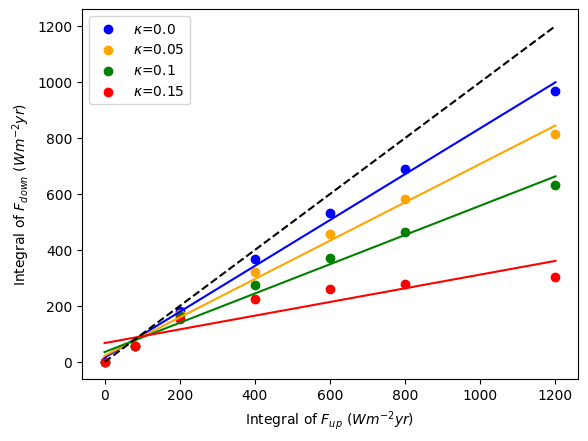

In [199]:
kappas = [0.0,0.05, 0.1, 0.15]
def IntegralFinder(run, run_name, kappa):
    """
    returns integrals needed for plots for a specific kappa and m
    """
    fint_up = []
    fint_down = [] 
    t_return = []
    

    t = int(run_name[run_name.find("= ")+2:run_name.find(", ")])

    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[run_name] = run.time[i][0]

    fint_up = 8 * t
    t_return = run.time[i][0]
    fint_down = 4 * (run.time[i][0]-t)
    
    

    return fint_up, fint_down,t_return

#def plotFupVFdown2(fint_up, fint_down, t_return, Plot = False):
fint_up_dic = {}
fint_down_dic = {} 
t_return_dic = {}
ms = {}
cs = {}
print(kappas)
for k in kappas:
    fint_up = []
    fint_down = [] 
    t_return = []
    for name in runManyKappas:
        #print(name)
        current_k = (name[name.find("k = ")+4:])
        if current_k == str(k):
            run = runManyKappas[name]
            fup, fdown, tback = IntegralFinder(run, name, k)
            
            fint_up.append(fup)
            t_return.append(tback)
            fint_down.append(fdown)
    print(fint_down, fint_up)
    A = np.vstack([fint_up, np.ones(len(fint_up))]).T
    m, c = np.linalg.lstsq(A, fint_down, rcond=None)[0]
    print("kappa: ", k, " m: ", m)

    fint_up_dic[k] = fint_up
    fint_down_dic[k] = fint_down
    t_return_dic[k] = t_return  
    ms[k] = m
    cs[k] = c
    

def shortPlotFints(kappas, ms, cs, fint_up_dic, fint_down_dic):

        colors = ['blue', 'orange', 'green', 'red', 'purple',
                      'black', 'cyan']
        fig, axs = plt.subplots()
        #fig.suptitle(f"Bouttes Parameters ")

        l, b, h, w = .2, .55, .15, .3

        # ax2 = fig.add_axes([l, b, w, h])
        # ax2.axhline(0, color="k")
        
        for p,k in enumerate(kappas):
            fint_up = fint_up_dic[k] 
            fint_down = fint_down_dic[k]
            m = ms[k]
            c = cs[k] 
            color = colors[p]

            xs = np.array(fint_up)
            residuals = (fint_down - ( m * xs + c) )
            axs.scatter(fint_up, fint_down, label = f"$\kappa$=%s"%k, color = color)
            axs.plot(xs, m * xs + c, color = color)


            #axs.annotate(f"m: %s"%"{:.2f}".format(m) , (xs[-1],fint_down[-1]+50))


            # ax2.scatter(xs, residuals, marker="x", s = 6)

        axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
        axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
        axs.plot(np.sort(xs), np.sort(xs), "k", linestyle= "dashed")
        
        axs.legend()

shortPlotFints(kappas, ms, cs, fint_up_dic, fint_down_dic)
    


In [202]:
def shortPlotFvsTemp(runs):
    colors = ['blue', 'orange', 'green', 'red', 'purple',
                      'black', 'cyan']
    
    for p,k in enumerate(kappas):
        c = colors[p]
        
        for name in runs: #looping until we find t_ofRun=100
        #print(name)
            current_k = (name[name.find("k = ")+4:]) 
            #print(k, current_k)
            if current_k != str(k):
                continue 
            i = name.index("t")
            j = name.index(",")
            t_run = int(name[i+4:j])
            if t_run != 150:
                continue 
            force = f_scenarios[t_run]
            f_up = np.cumsum(force[:t_run])
            f_down = np.cumsum(force[t_run:])
            run = runs[name]
            #plt.plot(run.time[::5], run.gammas, color = c, label = f"$\kappa$: %s"%k)
            plt.plot(f_up, run.tlev[:,1][:t_run], color = c, label = f"$\kappa$: %s"%k)
            plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t_run:][:250], linestyle = "dashed", color = c)

        plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
        plt.ylabel("Deep ocean Temperature change (K)")
        #plt.xlim(-500,3000)
        plt.legend()

    # arrowStart=np.array([400,-0.15])
    # arrowStop=np.array([600,0.58])
    # arrowColor="red"
    # plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+30,((arrowStop+arrowStart)/2)[1]) )
    # plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

    # arrowStart2=np.array([620,1.5])
    # arrowStop2=np.array([400,1])
    # arrowColor2="red"
    # plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
    # plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))
    # plt.title("Geoffroy Parameters with C/C_0 =5")

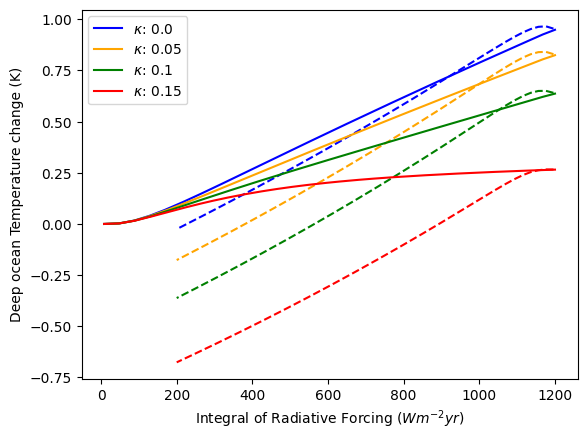

In [203]:
shortPlotFvsTemp(runManyKappas)